# Project: Personal Livability Index

### Shortcuts:
<ul>
<li><a href="#intro">Rationale, Project Goals and Deliverables </a></li>
<li><a href="data">Data Provenance</a></li>
<li><a href="#ega">Initial Data Exploration</a></li>
<li><a href="#next">Next Steps, Challenges, Summary</a></li>
</ul>

<a id='intro'></a>
## Rationale, Project Goals and Deliverables

### Rationale

The portion of employees able to work remotely is increasing, resulting in decoupling a company’s geographic location from worker’s choice of where to live. This opens up the possibility to choose where to live based on other metrics, such as local air quality, affordability, proximity to family, ‘good’ weather. 

Existing livability indices (e.g., https://en.wikipedia.org/wiki/Global_Liveability_Ranking) are useful yet limited. They are often based on annual data, rarely detailed at the global level, and most importantly they are not customizable. 

### Project Goals and Deliverables

The goal of this project is to build the first personalized livability web dashboard, one that lets the user weigh weather, transportation access, population density, air quality and a few other metrics.  This project will aggregate conventional livability metrics with personal preference inputs, such as weather preference and proximity to other cities (e.g., friends and family).  

When complete, some examples of questions answered by this project are:

> Given a preference for living by a body of water and in a country with high environmental and social governance scores, what is the most affordable city?

> I want to live as close as possible to my friends in Paris but I want to live in a warm climate where English is one of the official languages. Which cities satisfy my criteria?

Via the online dashboard, a user selects metrics of interst, assigns weights, and the results are generated as: 1) visualization of results as bar charts, 2) composite score and 3) ranked list of suitable places. A mock-up of the dashboard interface can be seen [here:](link to mock up in repo)    


<a id='data'></a>
## Data Provenance

* Public Datasets Used:

    * [World bank Environment,Social And Governance Data Catalogue ](https://datacatalog.worldbank.org/dataset/environment-social-and-governance-data)
    * [NOA GLobal] (ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/v4) Historical Climatology v4 data 
    * [World Health Organization] (https://apps.who.int/gho/data/node.home) datasets for ambient air pollution, road safety and health coverage
    * [IMF Global Housing Data](https://www.imf.org/external/research/housing/)


* Expanded Project Datasets (for inclusion later on):

    * The Economist [EIU’s liveability ratings](http://www.eiu.com/Handlers/WhitepaperHandler.ashx?fi=The_Global_Liveability_index_2018.pdf&mode=wp&campaignid=Liveability2018 "EUI page") for 140 cities around the world. Note this dataset requires a paid subscription
    * The [USA Livability website](https://livability.com/find-city)


<a id='ega'></a>
## Initial Data Explorations

The following plots demonstrate the availability of relevant data to support this project.  

In [ ]:
# Imports and magic words >>

import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime  
import re 
import xmltodict
import requests
from urllib.request import urlopen 
from bs4 import BeautifulSoup
 
%matplotlib inline


In [ ]:
# Make directory >>

folder_name = 'livability_raw_files'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    

# Download data files >>

def get_xml(url): # for world bank data 
    
    file = urlopen(url)
    data = file.read()
    file.close()
    data = xmltodict.parse(data)
    return(data)

def get_table(url): # for WHO data

    response = requests.get(url, timeout=10)
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find_all('table')[1]
    rows = table.select('tbody > tr')
    header = [th.text.rstrip() for th in rows[0].find_all('th')]
    
    scraped_contents = []   # empty list
    for tr in rows:
        row_cells = ([ tr.find('th').getText() ] if tr.find('th') else [] ) + [ td.getText().strip() for td in tr.find_all('td') if td.getText().strip() != '' ] 
        if len(row_cells) > 1 : 
            scraped_contents += [ row_cells ]
        

def get_wikitable(url): # for wikipedia tables
    
    response = requests.get(url).text
    soup = BeautifulSoup(response,'lxml')
    
    scraped_contents = []  
    for items in soup.find('table', class_='wikitable').find_all('tr')[1::1]:
        data = items.find_all(['th','td'])
        try:
            country = data[0].a.text
            language = data[1].a.text
        except IndexError:pass
        scraped_contents += [(country,language)]

dat_esg = get_xml('http://api.worldbank.org/v2/source/75/indicators')
dat_who = get_table('https://apps.who.int/gho/data/node.main.152?lang=en')
dat_who = get_table('https://apps.who.int/gho/data/node.main.A997?lang=en')
dat_lng = get_wikitable('https://en.wikipedia.org/wiki/List_of_official_languages_by_country_and_territory')
dat_hsg = pd.read_csv(folder_name,'/HousePrices.csv')


In [ ]:
...

In [78]:
# Subset of data for exploration

pti = pd.read_csv('pricetoincome.csv') # IMF data 2019 price-to-income ratio
pti.shape # (32,4)  # 32 countries
pti.columns = ['country_abr', 'country','pi_ratio','quarter']  
pti = pti[['country','pi_ratio']] # subset to country and pti ratio only

pm = pd.read_csv('WHO_ambientPM.csv') # WHO data 2016 ambient particulate matter
pm.shape # (194, 4) # 194 countries
pm.columns = ['country','pm25_total','pm25_urban','pm25_rural']
pm['pm25_total'] = pm['pm25_total'].astype(str).str.split(pat=None,n=1,expand=True)   # keep only mean not the range
pm['pm25_total'] = pm['pm25_total'].astype(float)

In [86]:
# Merge and filter data for visualization

df = pd.merge(pti, pm, on='country') 
df = df.iloc[:,0:3]
df = df.set_index('country')
df.head()

,pi_ratio,pm25_total
country,,
Portugal,124.514849,7.9
Luxembourg,122.273529,10.2
Hungary,120.981972,15.6
Netherlands,119.127623,12.1
Canada,118.457380,6.5


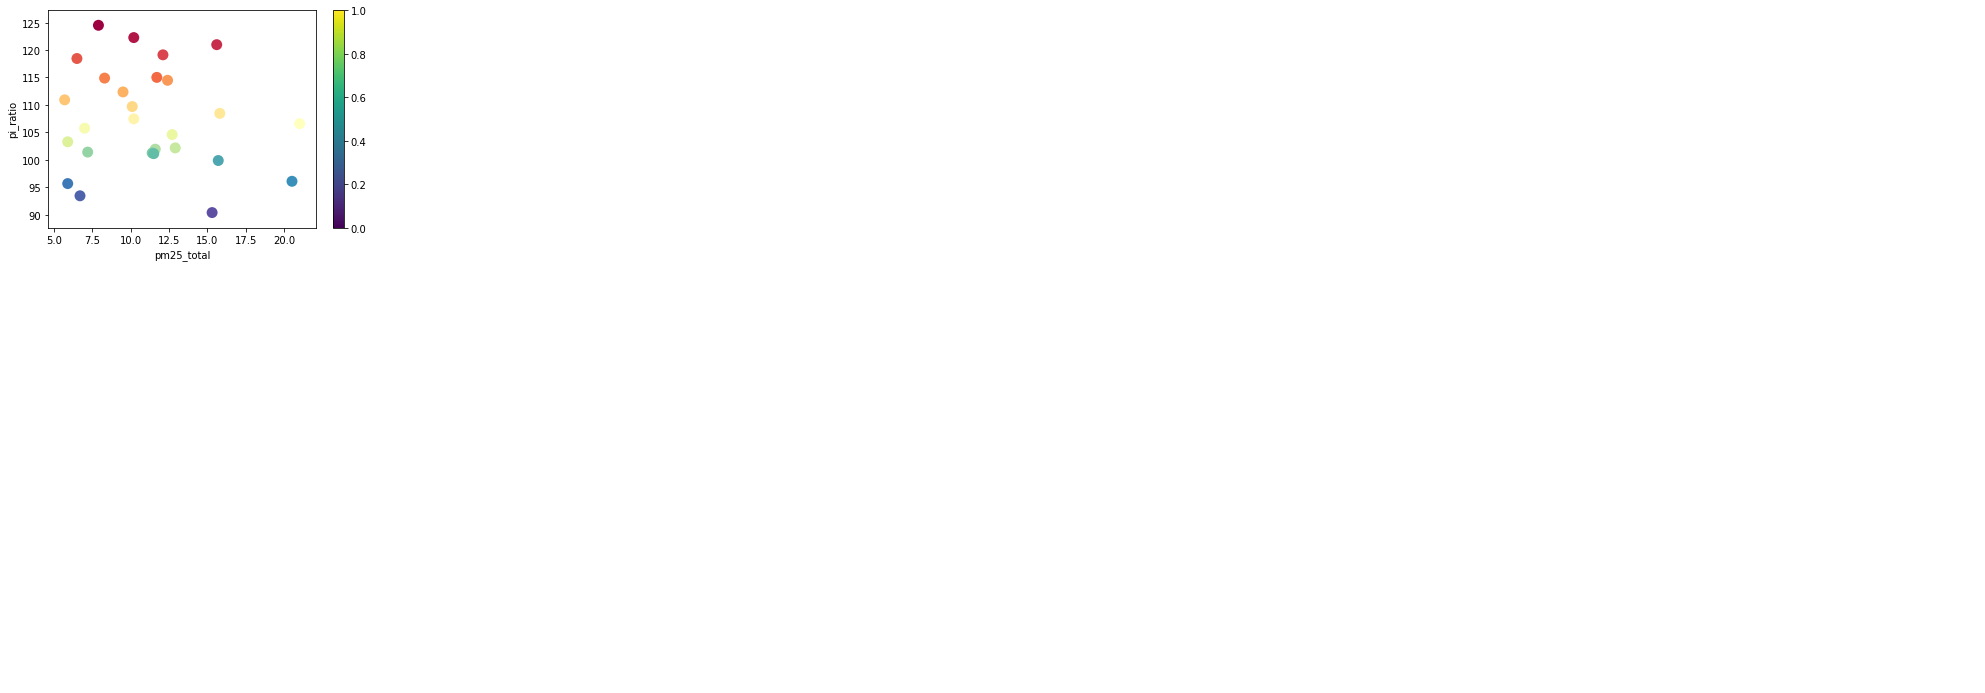

In [88]:
from matplotlib import cm

fig, ax = plt.subplots()
df.plot('pm25_total', 'pi_ratio', kind='scatter', ax=ax)

for i, j in df.iterrows():
    ax.annotate(i, j)

cmap = cm.get_cmap('Spectral')
df.plot('pm25_total', 'pi_ratio', kind='scatter', ax=ax, s=120, linewidth=0, 
        c=range(len(df)), colormap=cmap)

for i, j in df.iterrows():
    ax.annotate(i, j,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=18, color='darkslategrey')

<a id='next'></a>
## Next Steps, Challenges, Summary

### Outline of  steps

1. ~~Conceptualizing project and initial viability check.~~
2. Scrape clean and tidy remaining needed data 
3. Use Plotly’s Dash for proof-of-concept dashboard

A strength of this project is its scalability: the initial metrics are available by scraping and API downloads to immediately begin building a dashboard with a handful of metrics to start. Later on, or if time permits, it will be possible to layer on more features (such as incorporating multi-location living suggestions, as 6 months in two locations, to optimize for year-round weather!) Also, I'm sure I will get feedback that will open up new avenues to improve and explore...

### Addressing Anticipated Challenges

The main challenge of this project is the agglomeration of data from multiple sources. The datasets themselves are small; but they are vastly different - with different scopes and ways of documenting.  The exercise of bringing together the salient features, and aligning them to common keys (namely to locales), is the first challenge. 

As seen in the initial exploration of datasets, the scope of datasets differs. Thus some cities will have better 'coverage' of metrics. So far, the smallest dataset covers 32 countries, so there is still relatively good coverage. 


### In sum

Useful insights can arise from bringing together data that doesn't often appear side-by-side. My hope is that by combining disparate sources, in dynamic customizeable ways, the emerging picture will help guide decision-making about where to live. 

 
 